In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import shap
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif, RFE

### Data Processing

In [2]:
def data_process(df):
    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    df.fillna(df.mean(), inplace=True)
    
    # One hot encoding for Categorical Variables
    categorical_cols = ['sex', 'cp', 'restecg', 'exang', 'slope', 'thal']
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    categorical_encoded = encoder.fit_transform(df[categorical_cols])
    categorical_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out())
    
    df = df.drop(columns=categorical_cols)
    df = pd.concat([df, categorical_df], axis=1)

    """Split dataset into training and testing sets and standardize numerical features."""
    X = df.drop(columns=['target'])
    y = df['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize numerical features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test, X.columns

### ML Model Train & Evaluation

In [3]:
def train_models(X_train, y_train):
    # Hypermarapeters are adjusted to avoid overfittiong / underfitting
    models = {
        "Logistic Regression": LogisticRegression(penalty='l2', C=0.1),
        "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_leaf=10),
        "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=10),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=50,  learning_rate=0.05, )
    }
    
    for name, model in models.items():
        model.fit(X_train, y_train)
    
    return models

In [4]:
def evaluate_models(models, X_train, X_test, y_train, y_test):
    # Initial Metrics to track to compare models
    model_performance = {
        "Model Name": [],
        "AUC Score": [],
        "Training Accuracy": [],
        "Testing Accuracy": [],
        "Train-Test Gap": [],
        "Confusion Matrix (TN, FP, FN, TP)": [],
    }

    best_model = None
    best_accuracy = 0

    for name, model in models.items():
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_test_prob = model.predict_proba(X_test)[:, 1]

        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        auc_score = roc_auc_score(y_test, y_test_prob)
        train_test_gap = abs(train_acc - test_acc)

        # Confusion matrix values
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

        # Storing results
        model_performance["Model Name"].append(name)
        model_performance["AUC Score"].append(round(auc_score, 4))
        model_performance["Training Accuracy"].append(round(train_acc, 4))
        model_performance["Testing Accuracy"].append(round(test_acc, 4))
        model_performance["Train-Test Gap"].append(round(train_test_gap, 4))
        model_performance["Confusion Matrix (TN, FP, FN, TP)"].append((tn, fp, fn, tp))

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_model = (name, model)

    # Convert to DataFrame and sort by AUC Score to get the best model
    model_performance_df = pd.DataFrame(model_performance).sort_values(by="AUC Score", ascending=False)

    return model_performance_df, best_model

In [5]:
# Ploting the model performance side by side through heatmap for easier analysis
def plot_model_performance(df):
    df_plot = df.drop(columns=["Confusion Matrix (TN, FP, FN, TP)"])
    df_plot.set_index("Model Name", inplace=True)
    
    plt.figure(figsize=(8, 5))
    sns.heatmap(df_plot, annot=True, cmap="coolwarm", fmt=".4f")
    plt.title("Model Performance Heatmap")
    plt.show()


### Feature Importance

In [6]:
# To get Model Feature Importance
def get_feature_importance(model, model_name, feature_names):
    """Retrieve feature importance dynamically for selected models."""
    if hasattr(model, "coef_") and model.coef_.ndim == 2:  # Logistic Regression
        importance = np.abs(model.coef_[0])
    elif hasattr(model, "feature_importances_"):  # Decision Tree, Random Forest, Gradient Boosting
        importance = model.feature_importances_
    else:
        importance = None  # Handle cases where feature importance is not available

    if importance is not None:
        return pd.DataFrame({"Feature": feature_names, "Importance": importance}).sort_values(by="Importance", ascending=False)
    return None

In [7]:
# Plot Feature Importance for Best Model
def plot_feature_importance(feature_importance, model_name):
    """Plot feature importance using Seaborn."""
    if feature_importance is not None:        
        plt.figure(figsize=(8, 4))
        sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="coolwarm")
        plt.title(f"{model_name} Feature Importance")
        plt.show()


# Plot feature importance side by side for non-best models
def plot_all_feature_importance(non_best_models, feature_names):
    total_plots = len(non_best_models)
    plt.figure(figsize=(total_plots * 5, 5))
    
    for i, (model_name, model_instance) in enumerate(non_best_models.items(), 1):
        feature_importance = get_feature_importance(model_instance, model_name, feature_names)
        if feature_importance is not None:
            plt.subplot(1, total_plots, i)
            sns.barplot(x="Importance", y="Feature", data=feature_importance)
            plt.title(f"{model_name} Feature Importance")
            plt.tight_layout()
    
    plt.show()

In [8]:
# Other Feature Importance Methods
def compare_feature_importance_methods(model, model_name, feature_names, X_test, y_test):
    """Retrieve and visualize feature importance using multiple techniques."""
    importance_df = []

    # 1. Model-based feature importance (Logistic Regression, Tree-based models)
    if hasattr(model, "coef_") and model.coef_.ndim == 2:  # Logistic Regression
        importance = np.abs(model.coef_[0])
        importance_df.append(pd.DataFrame({
            "Feature": feature_names, 
            "Importance": importance, 
            "Method": "Model Coefficients"
        }))
    
    elif hasattr(model, "feature_importances_"):  # Tree-based models
        importance = model.feature_importances_
        importance_df.append(pd.DataFrame({
            "Feature": feature_names, 
            "Importance": importance, 
            "Method": "Tree Feature Importance"
        }))

    # 2. Permutation Importance (Applicable to All Models)
    perm_importance = permutation_importance(model, X_test, y_test, scoring="accuracy", n_repeats=10, random_state=42)
    perm_df = pd.DataFrame({
        "Feature": feature_names, 
        "Importance": perm_importance.importances_mean, 
        "Method": "Permutation Importance"
    })
    importance_df.append(perm_df)

    # 3. Mutual Information for Classification (Instead of Correlation)
    mutual_info = mutual_info_classif(X_test, y_test)
    importance_df.append(pd.DataFrame({
        "Feature": feature_names, 
        "Importance": mutual_info, 
        "Method": "Mutual Information"
    }))
    
    # 4. Recursive Feature Elimination (RFE)
    rfe_selector = RFE(estimator=model, n_features_to_select=1, step=1)
    rfe_selector.fit(X_test, y_test)
    # rfe_selector.ranking_: lower values mean higher importance.
    # Invert the ranking so that higher values indicate higher importance.
    importance_rfe = np.max(rfe_selector.ranking_) - rfe_selector.ranking_ + 1
    importance_df.append(pd.DataFrame({
        "Feature": feature_names, 
        "Importance": importance_rfe, 
        "Method": "RFE"
    }))
    
    # Combine all results
    final_df = pd.concat(importance_df).sort_values(by=["Method", "Importance"], ascending=False)
    
    return final_df

def plot_feature_importance_all_methods(feature_importance, model_name):
    # Separate RFE from other methods
    non_rfe = feature_importance[feature_importance['Method'] != 'RFE']
    rfe_data = feature_importance[feature_importance['Method'] == 'RFE']
    
    # Create two subplots: one for non-RFE and one for RFE
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
    # Plot non-RFE methods
    sns.barplot(x='Importance', y='Feature', hue='Method', data=non_rfe, dodge=True, palette="Set2", ax=axes[0])
    axes[0].set_title("Non-RFE Feature Importance")
    axes[0].legend(loc="best")
    
    # Plot RFE method separately
    sns.barplot(x='Importance', y='Feature', data=rfe_data, color="lightblue", ax=axes[1])
    axes[1].set_title("RFE Feature Importance")
    axes[1].set_xlabel("RFE Importance")
    
    # Overall title for the figure
    fig.suptitle(f"{model_name} Feature Importance Across Methods", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### Execute Functions


Model Performance Summary:
         Model Name  AUC Score  Training Accuracy  Testing Accuracy  Train-Test Gap Confusion Matrix (TN, FP, FN, TP)
Logistic Regression     0.9472             0.8595            0.8852          0.0257                    (27, 2, 5, 27)
      Random Forest     0.9321             0.8512            0.8361          0.0152                    (25, 4, 6, 26)
  Gradient Boosting     0.8944             0.9298            0.8197          0.1101                    (25, 4, 7, 25)
      Decision Tree     0.8739             0.8388            0.7869          0.0520                    (25, 4, 9, 23)


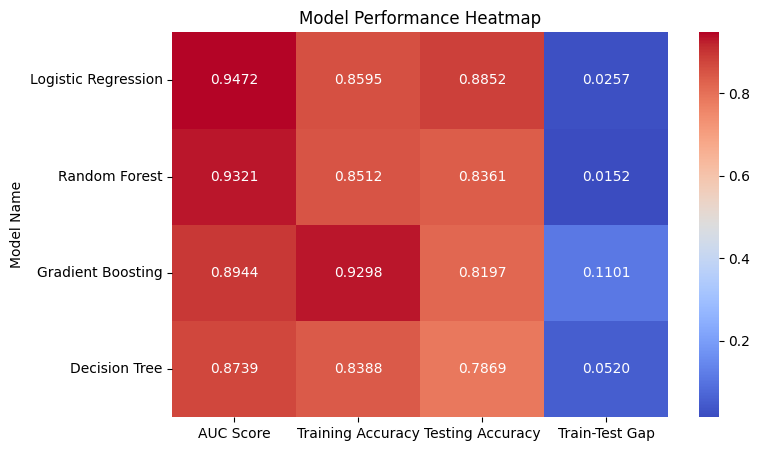


Best Model: Logistic Regression with Accuracy = 0.8852


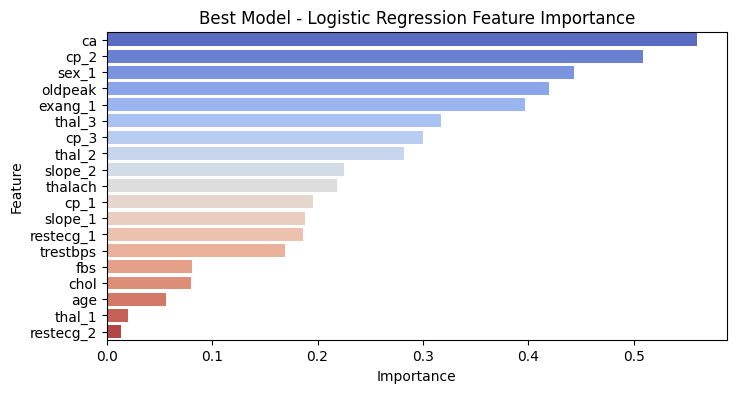

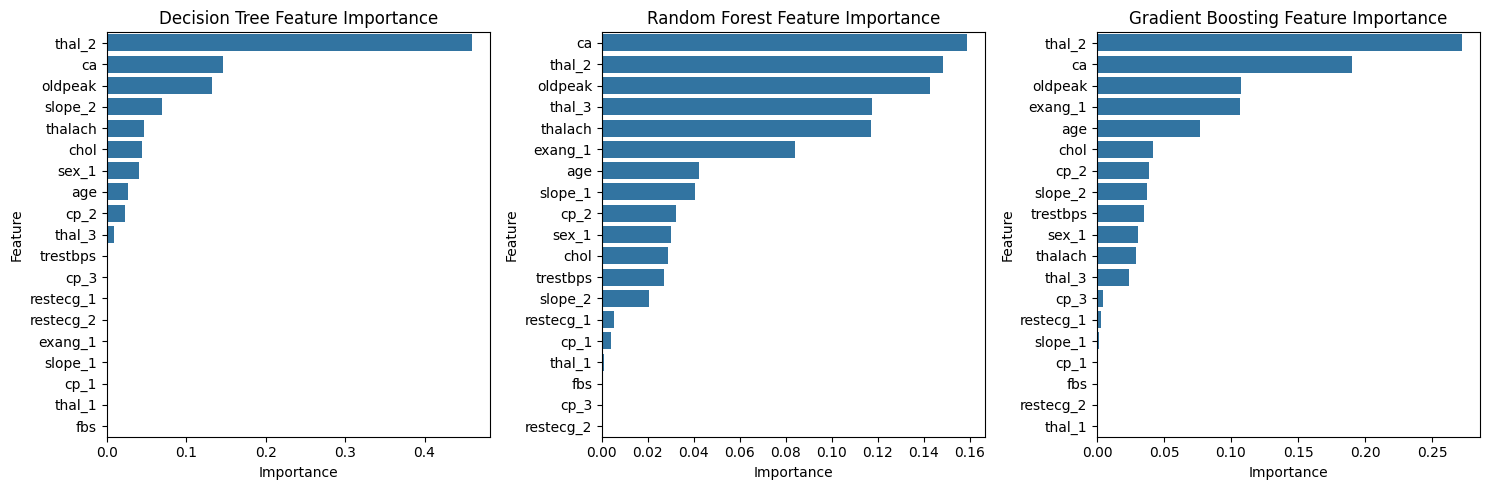

In [9]:
# Main execution
df = pd.read_csv("cancer_data.csv")
X_train, X_test, y_train, y_test, feature_names = data_process(df)
models = train_models(X_train, y_train)
model_performance_df, best_model = evaluate_models(models, X_train, X_test, y_train, y_test)

print("\nModel Performance Summary:")
print(model_performance_df.to_string(index=False))

# Plot: All Model Performance for Evaluation
plot_model_performance(model_performance_df)

# Best model feature importance
best_model_name, best_model_instance = best_model
print(f"\nBest Model: {best_model_name} with Accuracy = {model_performance_df[model_performance_df['Model Name'] == best_model_name]['Testing Accuracy'].values[0]:.4f}")
feature_importance_best = get_feature_importance(best_model_instance, best_model_name, feature_names)
plot_feature_importance(feature_importance_best, f"Best Model - {best_model_name}")

# Plot all models' feature importance except the best one
non_best_models = {name: model for name, model in models.items() if name != best_model_name}
plot_all_feature_importance(non_best_models, feature_names)

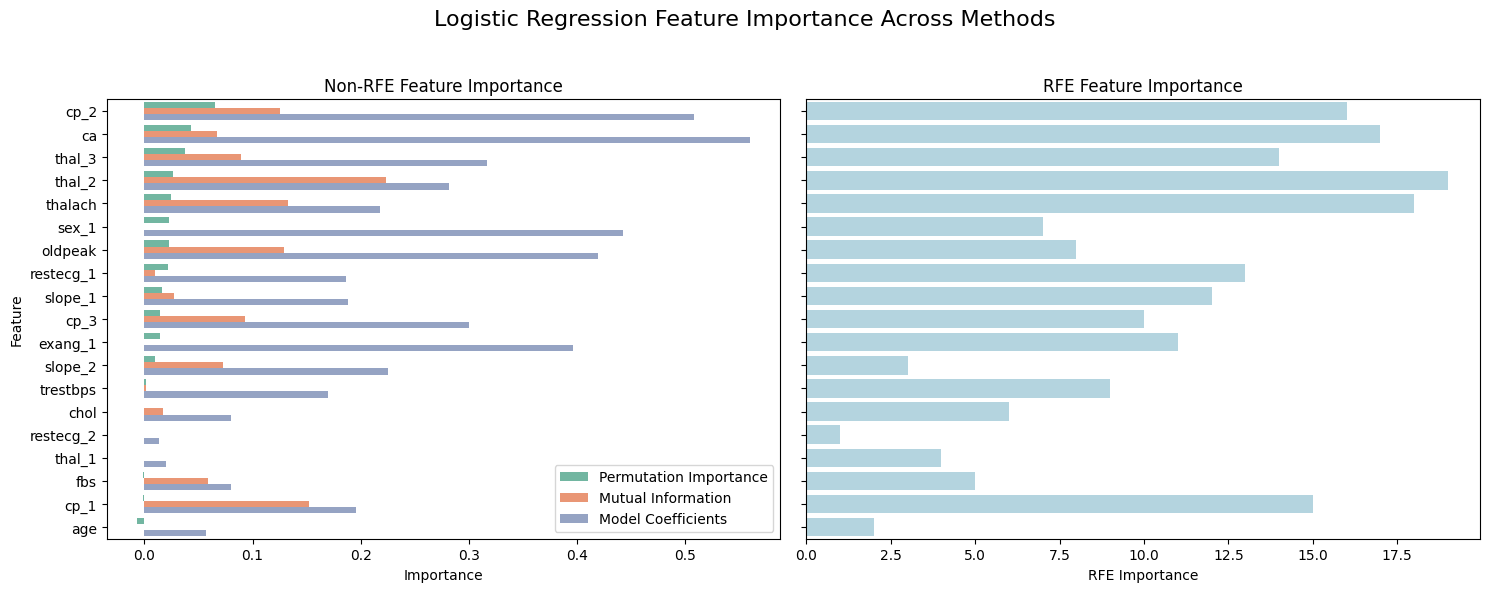

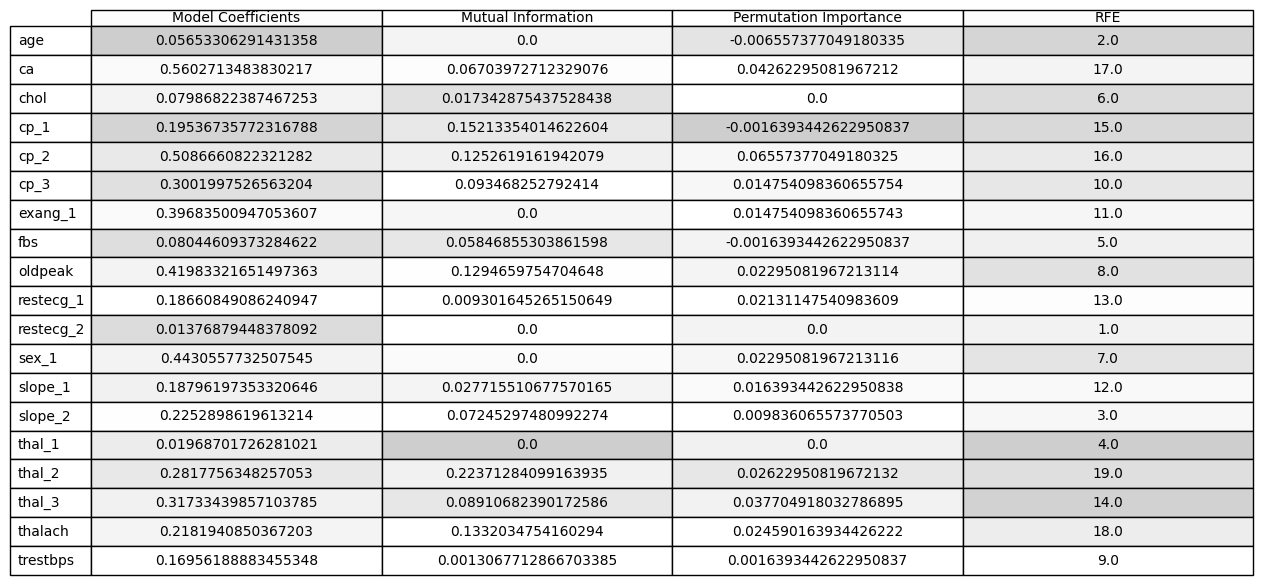

In [10]:
# Feature Importance: Different Methods
feature_importance_best = compare_feature_importance_methods(best_model_instance, best_model_name, feature_names, X_test, y_test)
plot_feature_importance_all_methods(feature_importance_best, best_model_name)


final_df_pivoted = feature_importance_best.pivot_table(index="Feature", columns="Method", values="Importance", aggfunc="mean")
final_df_pivoted.columns = [col for col in final_df_pivoted.columns]
final_df_pivoted = final_df_pivoted.reset_index()
final_df_pivoted = final_df_pivoted.set_index('Feature')

# Create a figure and axis for the table
fig, ax = plt.subplots(figsize=(15, 2.5))  # Increased height for better readability

# Add the table to the figure using ax.table
table = ax.table(cellText=final_df_pivoted.values,
                colLabels=final_df_pivoted.columns,
                rowLabels=final_df_pivoted.index,
                loc='center', cellLoc='center', colLoc='center')

# Normalize each column to apply lighter shading based on values
for (i, j), val in np.ndenumerate(final_df_pivoted.values):
    column_max = np.nanmax(final_df_pivoted.values[:, j])  
    color = plt.cm.Greys(val / column_max * 0.3)  
    table[(i, j)].set_facecolor(color)  

# Table Formatting
table.auto_set_font_size(False)
table.set_fontsize(10)  
row_height = 0.15  

# Data Row Height
for i in range(len(final_df_pivoted.index)):
    for j in range(len(final_df_pivoted.columns)):
        table[(i+1, j)].set_height(row_height)

# Index Row Height
for i in range(len(final_df_pivoted.index)):
    table[(i+1, -1)].set_height(row_height)  # Set the index row height

# Font Color
for (i, j) in table.get_celld().keys():
    table[(i, j)].set_text_props(color='black')  # Ensure all text is black

ax.axis('off') 

plt.show()

In [11]:
X_train, X_test, y_train, y_test, X_columns = data_process(df)

for model_name, model in models.items():
    
    if hasattr(model, 'coef_'):  # Logistic Regression
        coef_df = pd.DataFrame(model.coef_.T, index=X_columns, columns=[model_name])
        coef_df['Interpretation'] = coef_df[model_name].apply(
            lambda x: f"Increase by {x:.2f} log-odds per unit increase in feature" if x > 0 else f"Decrease by {abs(x):.2f} log-odds per unit increase in feature"
        )

    
    elif hasattr(model, 'feature_importances_'):  # Tree-based models
        feature_importance_df = pd.DataFrame(model.feature_importances_, index=X_columns, columns=[model_name])
        feature_importance_df['Interpretation'] = feature_importance_df[model_name].apply(
            lambda x: f"Feature importance value: {x:.3f}, higher means more important" if x > 0 else "Feature is not important"
        )
        
    else:
        print("No coefficients or feature importances available for this model.")

In [19]:
# Add a Risk Column
coef_df["Risk Impact"] = coef_df["Logistic Regression"].apply(lambda x: "Lower Risk (Negative)" if x < 0 else "Higher Risk (Positive)")
coef_df = coef_df.sort_values(by="Logistic Regression", ascending=False)

# Function to apply conditional formatting
def highlight_coeffs(val):
    color = 'lightblue' if val < 0 else 'lightcoral'
    return f'background-color: {color}'

# Apply formatting
styled_df = coef_df.style.applymap(highlight_coeffs, subset=["Logistic Regression"]).set_properties(
    **{'text-align': 'center'}
).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
)

In [20]:
styled_df

,Logistic Regression,Interpretation,Risk Impact
cp_2,0.508666,Increase by 0.51 log-odds per unit increase in feature,Higher Risk (Positive)
cp_3,0.300200,Increase by 0.30 log-odds per unit increase in feature,Higher Risk (Positive)
thal_2,0.281776,Increase by 0.28 log-odds per unit increase in feature,Higher Risk (Positive)
slope_2,0.225290,Increase by 0.23 log-odds per unit increase in feature,Higher Risk (Positive)
thalach,0.218194,Increase by 0.22 log-odds per unit increase in feature,Higher Risk (Positive)
cp_1,0.195367,Increase by 0.20 log-odds per unit increase in feature,Higher Risk (Positive)
restecg_1,0.186608,Increase by 0.19 log-odds per unit increase in feature,Higher Risk (Positive)
fbs,0.080446,Increase by 0.08 log-odds per unit increase in feature,Higher Risk (Positive)
thal_1,0.019687,Increase by 0.02 log-odds per unit increase in feature,Higher Risk (Positive)
restecg_2,-0.013769,Decrease by 0.01 log-odds per unit increase in feature,Lower Risk (Negative)
